# Неделя Трансформеров: День 1 — Attention, революция!

Разбираем статью, без которой не было бы ЯндексGPT и ГигаЧата.

8 лет назад, 2017 год (как время-то летит, однако). В мире творится магия:
Кто-то еще смотрит «Игру престолов», а трансформеры уже готовятся к захвату мира.
Вышла статья Attention is All You Need, перевернувшая NLP.

Сегодня мы будем разбираться, почему все так помешались на трансформерах.

Наша дорожная карта:

1. Внимание: Attention и Multihead Attention — подробно разбираем ядро.
2. Очень краткий обзор остальных компонентов
3. Собираем трансформер как Lego.

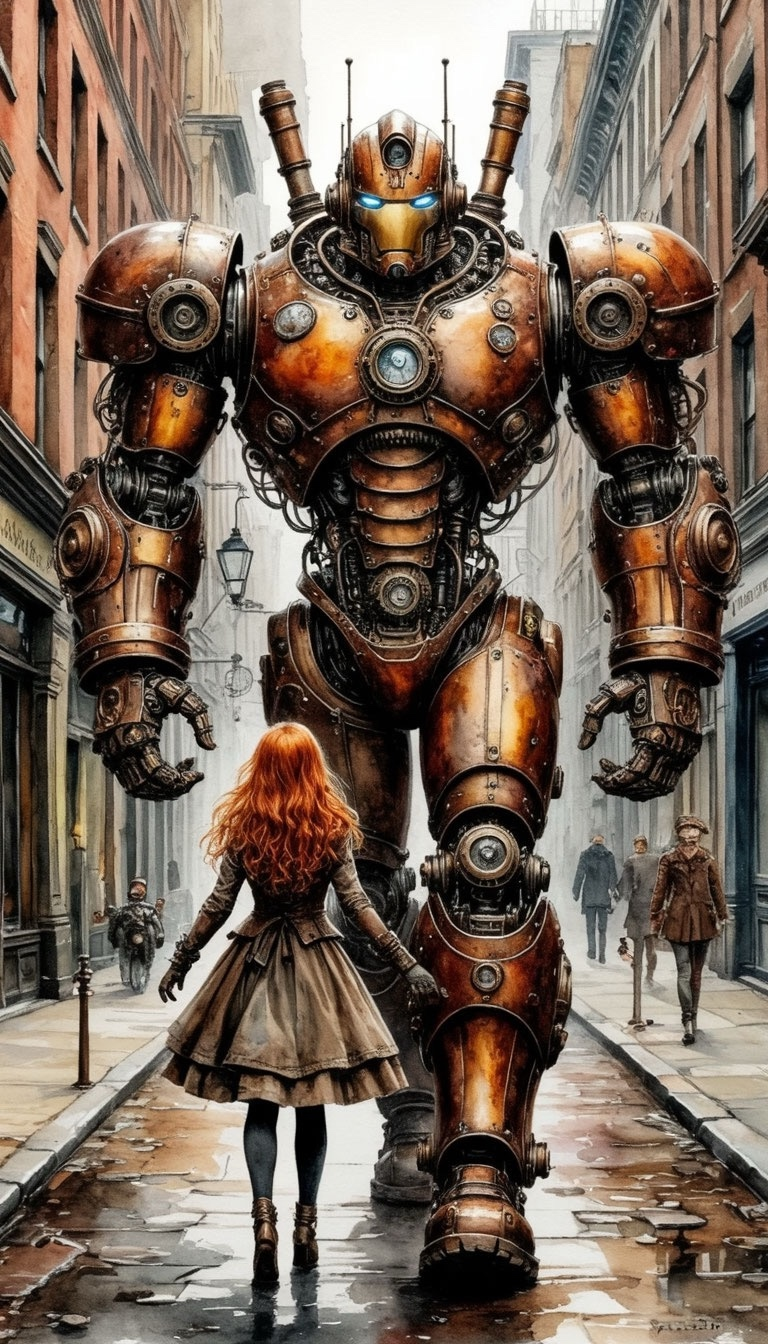

In [24]:
from IPython.display import Image
Image('1_Title.jpg', width=300, height=150 )

Иллюстрация вдохновлена работами автора  https://shedevrum.ai/profile/qk9hbb6u5ufqhukd64qg2uua3r?share=2ayyrvpt4ggaxjgfvq1r32gkw0 (Инкогнито 8595).

# Содержание
    0. Предварительные замечания
    1. Механизм (само)внимания: (Self-)Attention, Multihead (Self-)Attention 
    2. Энкодер+Декодер=Трансформер
    3. Заключение

# 0. Предварительные замечания. 

## Дисклеймер 
В рамках данного цикла я не рассказываю подробно, что такое обучение моделей. Будем считать, что это процесс, по входящим данным и фиксированной функции (потерь) модифицирующий параметры (веса) модели, желательно, к лучшему.

Предполагается, что у читателя есть некоторые воспоминания о школьной математике и скалярном/матричном произведении.

Ну а если Вы можете легко и спонтанно прочитать оригинальную статью https://arxiv.org/pdf/1706.03762 (Google Brain and Google Research) и туториал на Keras к ней https://www.tensorflow.org/text/tutorials/transformer?hl=ru
, то здесь Вы вряд ли узнаете что-то новое)

## Стратегия 
Авторы статьи вводят не очень стандартное обозначение Sublayer для функции, возвращающей вектор фиксированной длины $d_{model}$ (которая является гиперпараметром модели). 
В то время как слоем (блоком) обычно называют функцию, принимающую вектор на вход и возвращающую вектор на выходе (без априорных предположений об их длине)
https://education.yandex.ru/handbook/ml/article/pervoe-znakomstvo-s-polnosvyaznymi-nejrosetyami

Поэтому здесь будем использовать такие обозначение: 

блок = функция: вектор->вектор, 

и его частный случай Sublayer = функция: вектор->вектор длины $d_{model}$.

Мы разберем подробно механизмы (Self-)Attention и его обобщение Multihead (Self-)Attention, отражающие главную идею оригинальной статьи. Затем кратко пробежимся по остальным блокам трансформера и соберем его из этих блоков. Чтобы заранее не пугать читателей, схема всего трансформера будет показана после механизма внимания (рисунок 3).

Оригинальный трансформер разрабатывался для задачи перевода с одного языка на другой, поэтому входящими данными для него являются слова, которые надо зашифровать числами. Результаты их  кодирования называются эмбеддингами. (Кодировать таже можно пары, тройки,... нескольких слов или части одного слова) 

Чтобы не запутаться в размерностях, выход всех подслоев в модели, а также эмбеддинги, имеют одинаковую размерность - иперпараметр $d_{model} = 512$. Также зафиксируем остальные гиперпараметры модели (их назначение будет раскрываться в течение текста): $d_{ff} = 2048$, $N_x = 6$, $h=8, d_k = d_q = d_v = d_{model}/h = 64$ (хотя $d_k$ и $d_v$ совпадают в статье, идейно они не связаны, и мы распишем все в более общем виде, совпадение $d_k = d_q$ принципиально).

# 1. Механизм (само)внимания: (Self-)Attention, Multihead (Self-)Attention  

## Attention блок

Знаменем архитектуры трансформеров, ее основной математической конструкцией является функция матриц:
$$Attention(Q, K, V) = softmax\left(\frac{Q\cdot K^T}{\sqrt{d_k}}\right)\cdot V,$$
где $Q = Q(X), K = K(X), V = V(X)$, а $X$ - входящие данные.

В этом механизме обозначения имеют следующий смысл:

$\sqrt{d_k}$ - корень из гиперпараметра - входит в формулу как нормировочный множитель, чтобы матричное (а по сути скалярное) произведение не росло слишком быстро,

$softmax(Z)_{ij} = exp(z_{ij})/ \sum_j(exp(z_{ij}))$ - построчная нормировка, для той же цели.

Матрицы  Q - queries, K - keys ,  V - values: определяются следующим образом: пусть X - матрица размера $(В, d_{model})$, строки которой - эмбеддинги интересующих нас слов, B - размер батча (число обрабатываемых моделью за раз строк). $W_q$, $W_k$, $W_v$ - обучаемые параметры (веса) - матрицы размера $(d_{model}, d_q)$, $(d_{model}, d_k)$, $(d_{model}, d_v)$ соответственно $(d_q = d_k)$. Тогда $$Q = X\cdot W_q, \qquad K = X \cdot W_k, \qquad V = X\cdot W_v.$$
    
Таким образом, матрицы имеют следующие размеры: 
$$X.shape = (В, d_{model}),$$ 
$$Q.shape = K.shape = (B, d_k), \qquad V.shape = (B, d_v),$$ 
$$(Q\cdot K^T).shape = (B, B),$$
$$\left(softmax\left(\frac{Q\cdot K^T}{\sqrt{d_k}}\right)\cdot V\right).shape = (B, d_v).$$
Описанная конструкция визуализирована на рисунке 1. 

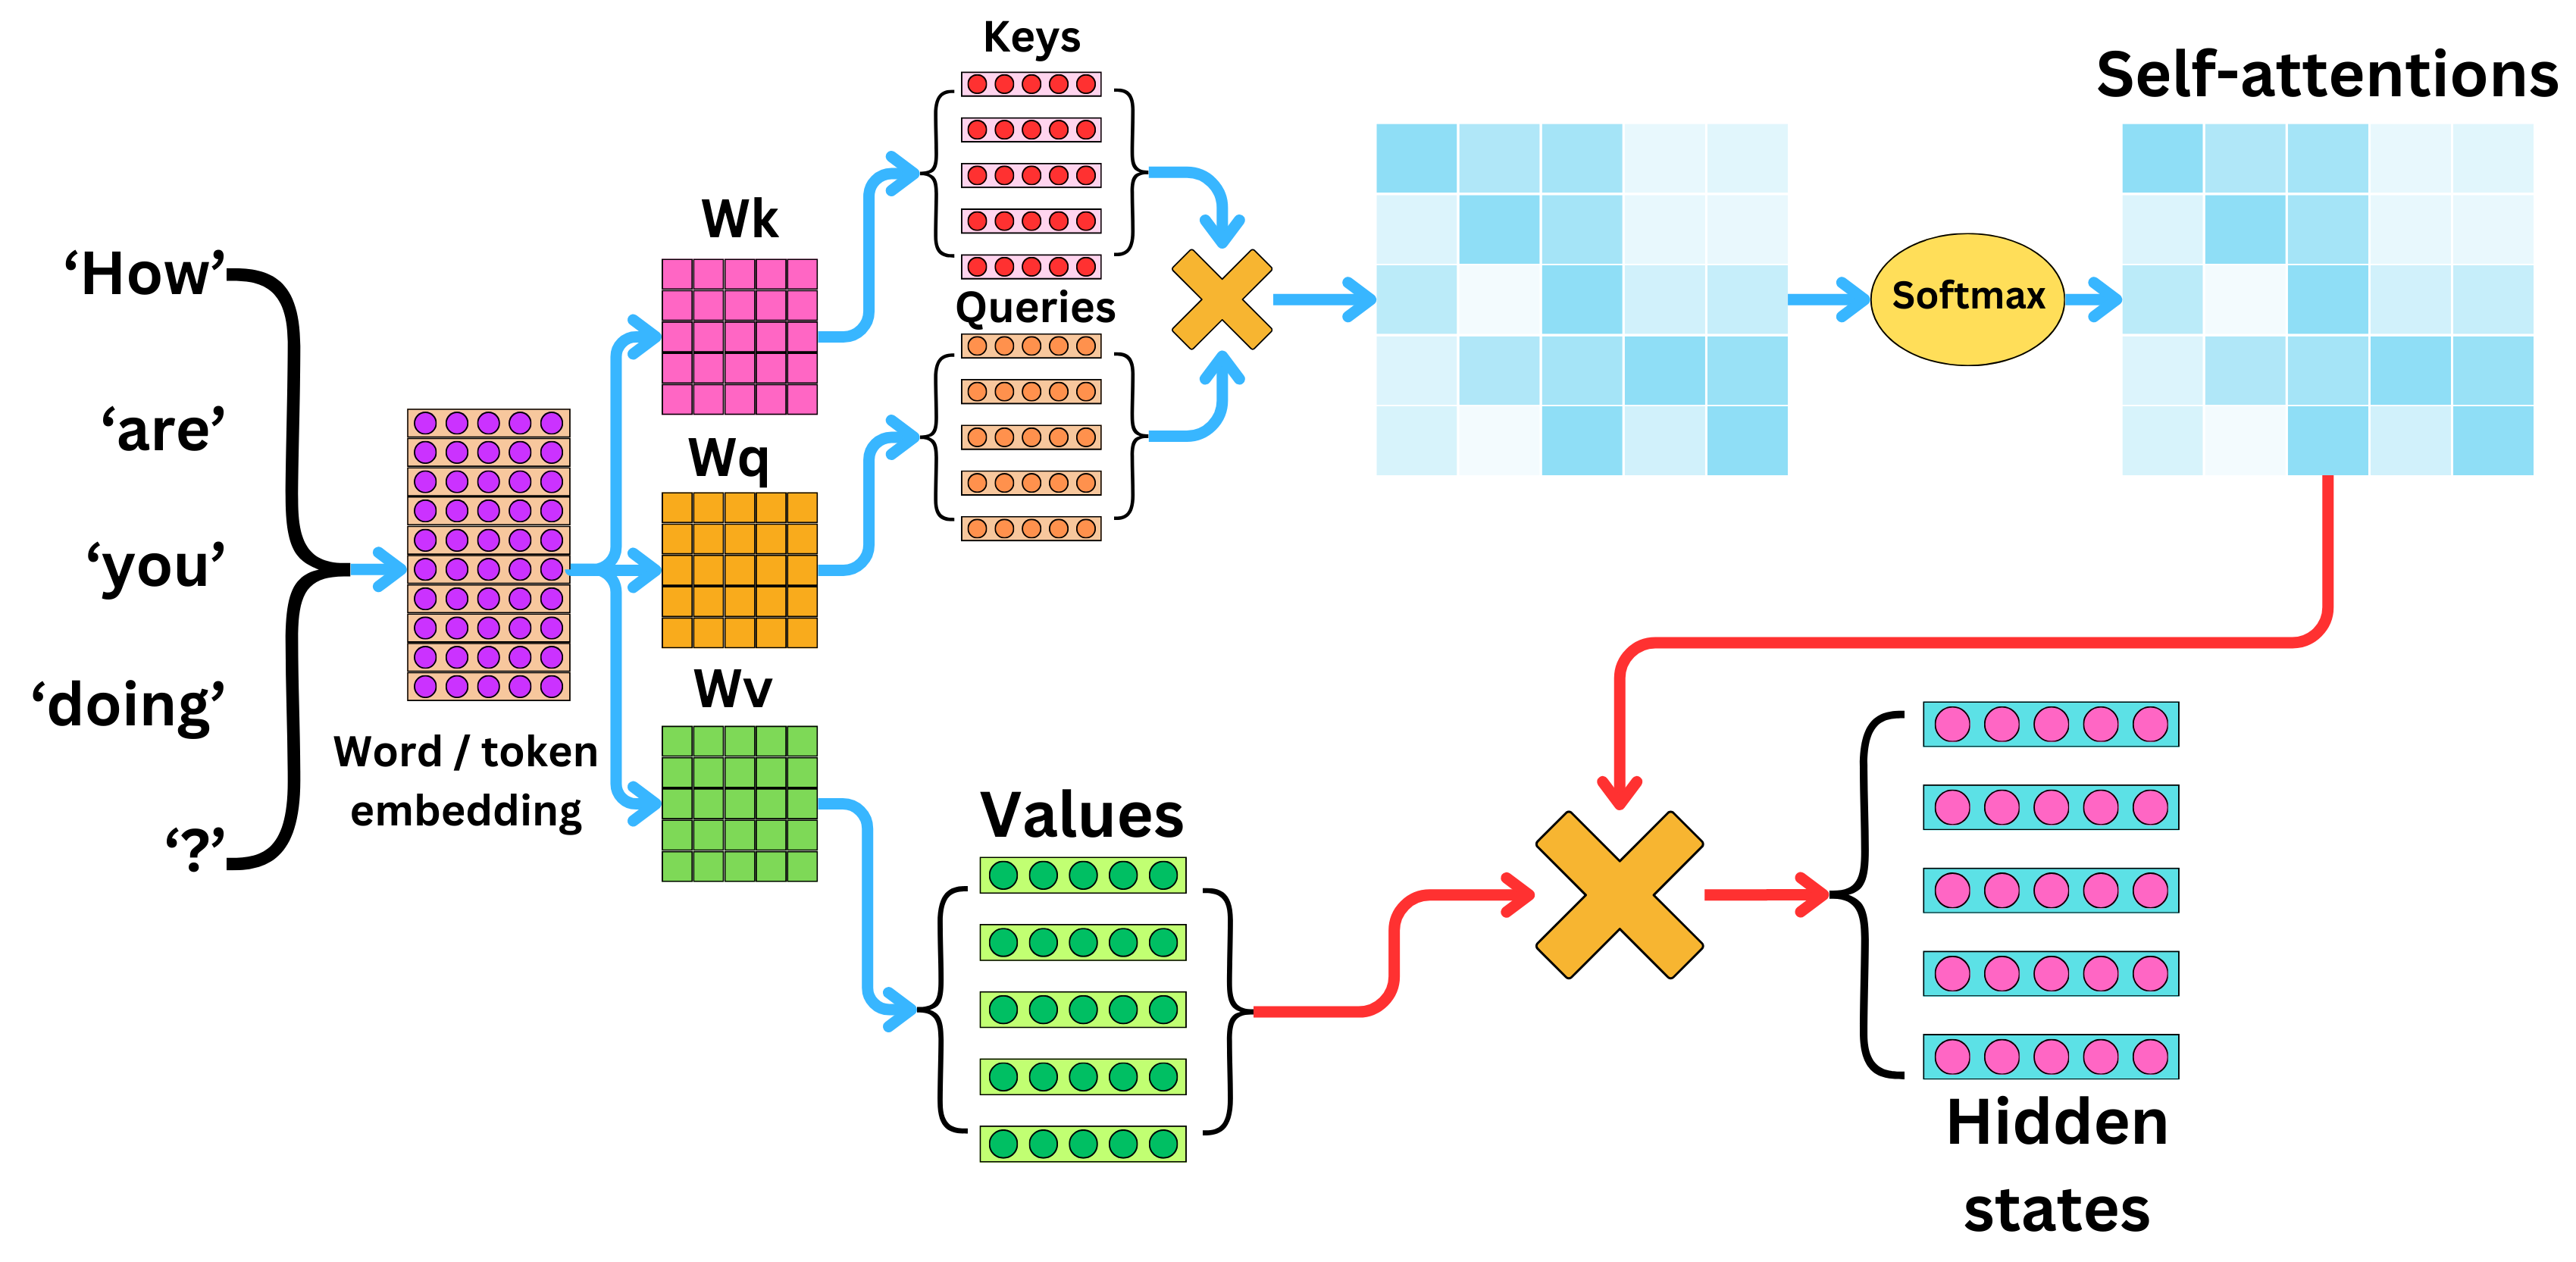

In [25]:
Image('1_1.png', width=600, height=300 )

Рисунок 1
https://newsletter.theaiedge.io/p/understanding-the-self-attention
Строго говоря, у матриц $W_{q,k, v}$ ширина по правилу умножения матриц должна быть побольше.

## Интерпретация Attention
У Q, K, V существует общепринятая интерпретация: Q - "запрос", K - "краткая сводка" и V - "документ", Attention позволяет понять, насколько "документ" релевантен "запросу". Хотя с математической точки зрения, это просто умножение X на матрицы, которые как-то обучились. Но математика дает нам другой инсайт: скалярное произведение $Q\cdot K^T$ вычисляет сонаправленность векторов: каждая строка этой матрицы - в некотором смысле сходство между эмбеддингом и всеми другими эмбеддингами в этом батче. Эту матрицу внимания можно рассматривать как «фильтр», который мы применяем к V.

**И вот тут возникает "вау"-момент.** Если $B$ достаточно большое, можно взять хоть весь переводимый текст сразу, что позволяет учитывать контекст, связь даже между первым и последним словом. Просто за счет умножения матриц, которое изучается на 1 курсе универа, и алгоритмы для которого изучались с 1750-х годов. До изучаемой сегодня работы данные обрабатывались  последовательно в некотором скользящем окне c помощью громоздких нейронных сетей, таких как RNN, LSTM, и контекст в процессе движения окна постоянно искажался. Теперь у нас весь текст/батч как на ладони.

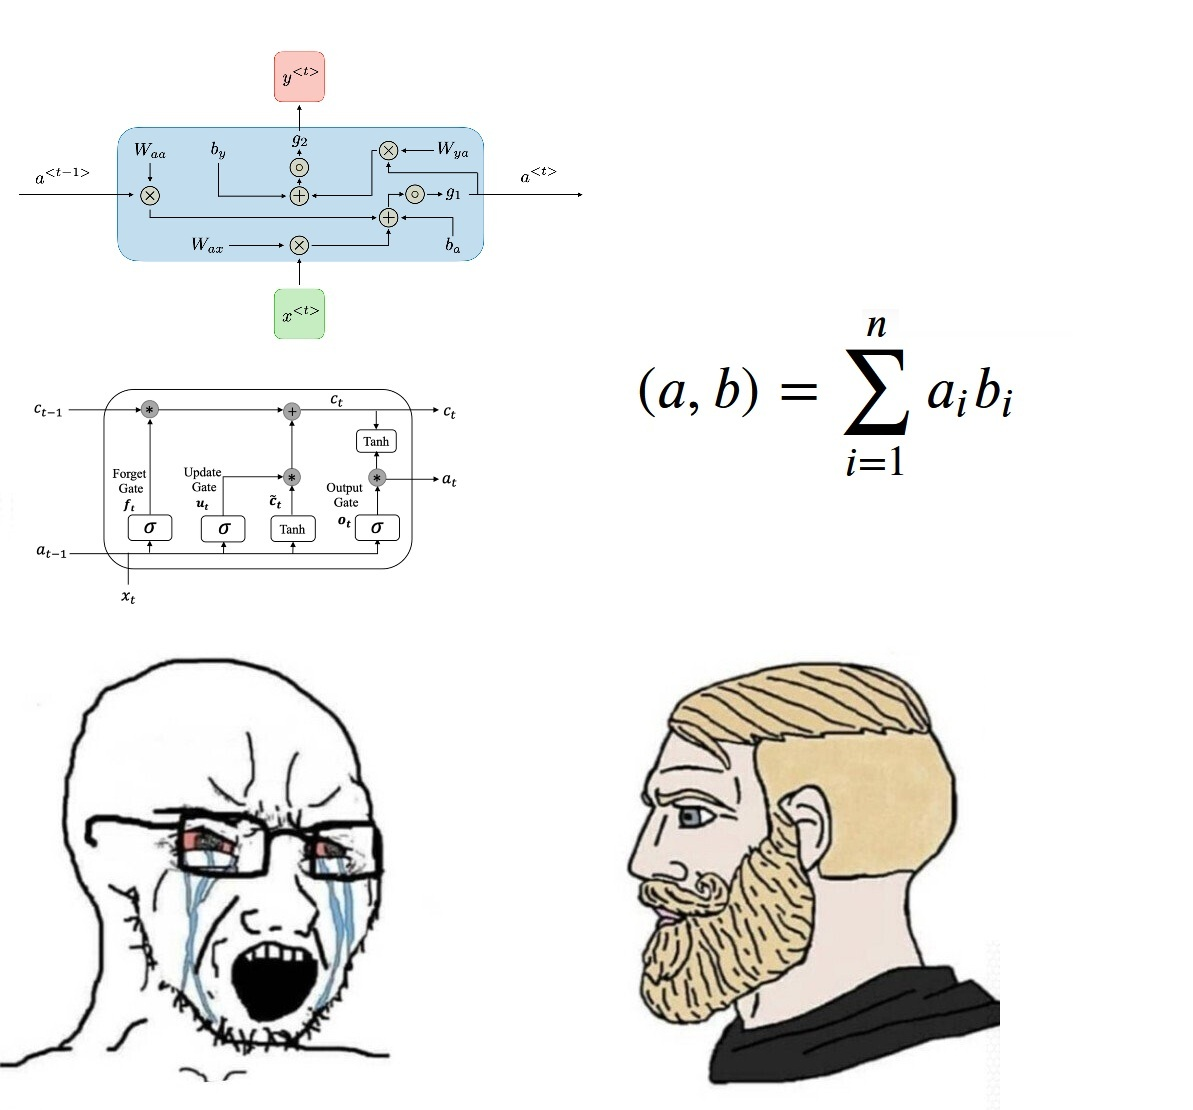

In [26]:
Image('1_mem_1.jpeg', width=500, height=300 )

**Замечание:** Авторы оригинальной статьи также затрагивают факт,
что вместо матричного произведения можно взять нейронную сеть с одним скрытым слоем.
Для малых $d_k$ произведение и нейронка работают примерно одинаково, для больших - нейросеть явно лучше. Обученный скрытый слой также может хранить информацию о взаимосвязи разных эмбеддингов, но (за счет плохой интерпретируемости многослойных перцептронов) в менее явном виде, чем матричное  произведение.

## Multihead attention

Казалось бы, можно сделать один большой Attention, $d_q = d_k = d_v = d_{model}$, обучить весь контекст и радоваться жизни. Но тут вступает в дело **второй "вау"-момент**. Матричные вычисления отлично распараллеливаются, и это распараллеливание можно еще немного усилить, и даже выжать из текста дополнительную информацию!

Мы следуем обозначениям оригинальной статьи, где в этом месте есть некоторая рассогласованность, поэтому я добавлю дополнительные замечания.

Multi-head Attention подразумевает что блоков ("голов") Attention одинакового размера будет несколько. А именно, h (тот самый введенный выше гиперпараметр), а размер V определяется по формуле $d_v = d_{model}/h$ (при изменении гиперпараметров $d_v$ должно оставаться натуральным!).

На вход в блок Multi-head Attention поступает матрица X размера $(В, d_{model})$. Для нее считаем Q, K, V с помощюю матриц $W_q$, $W_k$, $W_v$ размера $(d_{model}, d_{model})$ один раз, причем это **не те** матрицы, что были в разделе "Attention блок" аргументами функции Attention. 

Введем 3h линейных блоков Linear, действие которых описывается формулой $y = x\cdot W$, где $W = W_i^{Q,K,V}$, $i=1...h$, причем размеры матриц весов $W_i^{Q, K, V}.shape = (d_{model}, d_{q, k, v})$ соответственно. И $(Q\cdot W^Q_i, K\cdot W^K_i, V\cdot W^V_i)$ это как раз **те самые** матрицы. 

В соответствии с посчитанным выше, после работы всех голов у нас получается h матриц размера $(B, d_v)$. Конкатенируем их вдоль оси x (будем соединять их слева/справа, пока не получим матрицу размера $(B, d_{model})$.

Опционально (см. рисунок 2) можно задать маску, обнуляющую некоторые элементы произведения матриц $Q\cdot K^T$. 
Эта маска является принципиальной в декодере, где она помогает избежать утечек данных.
Поскольку у нас есть softmax, в коде это реализуется прибавлением большого отрицательного числа к элементу произведения матриц, обнуляющего соответствующую экспоненту.

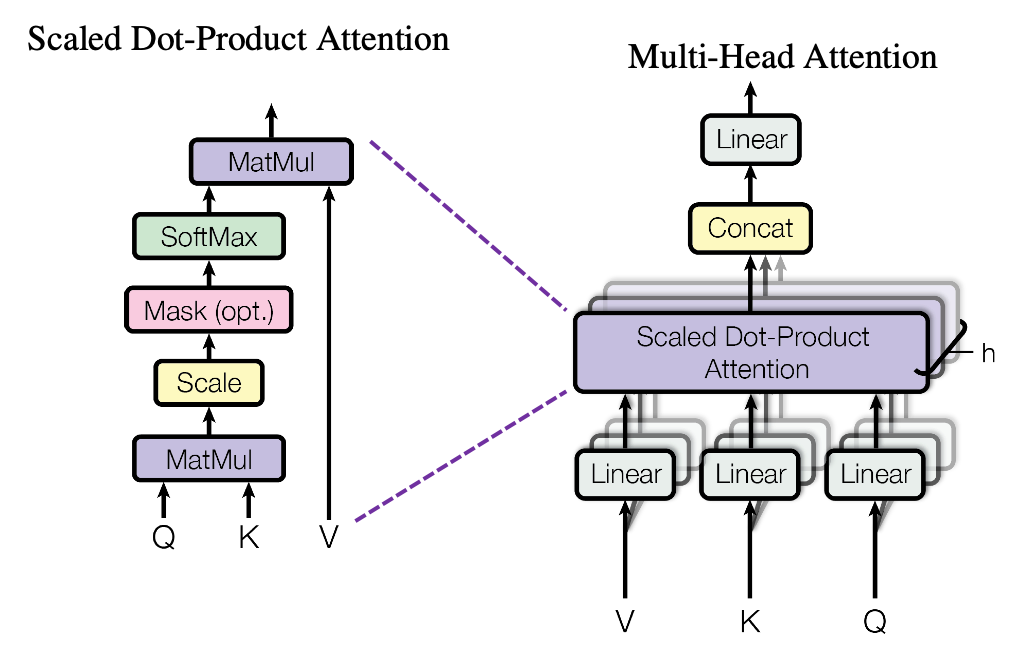

In [27]:
 Image('1_2.png', width=750, height=300)

Рисунок 2. Слева - компактное изображение self-attention, 
справа - multi-head attention.

Небольшая неточность: если слева одна из "голов", то у нее на входе должны быть матрицы $(Q\cdot W^Q_i, K\cdot W^K_i, V\cdot W^V_i)$, в оригинальной статье эти рисунки не связаны.

Общепринята такая интерпретация Multi-head Attention: Поскольку эти блоки независимы, они извлекают разную информацию из входных данных.

Но если мы остановимся на этом шаге, у нас будет просто склеенный набор несвязной информации. Чтобы установить взаимосвязи, присоединим сверху еще один Linear-блок с матрицей весов $W^O$ размера $(d_{model}, d_{model})$.

Таким образом, у нас получился Sublayer! 

Собственно, здесь описаниие Attention кончается, далее коротко опишем несколько типов блоков, которые нам понадобятся плюс разные технические вещи, на которых мы не будем заострять **внимания**. И, наконец, опишем присоединение блоков друг к другу.

#  2. Энкодер+Декодер=Трансформер

## Три блока, которые нам понадобятся далее


### 1) и 2) Linear и FeedForward

Нам потребуется еще один Linear-блок и аналогичный ему нелинейный двуслойный

FeedForward-блок (для вектора x имеет вид): $y = W_2\cdot\sigma(x\cdot W_1 + b_1) + b_2$, 

где $\sigma(x) = ReLu(x) = max(0, x)$, применяется к каждому элементу,

$len(x)=len(y)=len(b_2)=d_{model}$, 

$len(b_1)=d_{ff}$, 

$W_1.shape=(d_{model}, d_{ff}), W2.shape=(d_{model}, d_{ff}).$

Где гиперпараметр $d_{ff} = 2048$ мы фиксировали вначале вместе с остальными.

### 3) Add&Norm
Здесь имеет место инженерный трюк (Остаточные связи): для борьбы с так называемым "исчезающим градиентом при обучении" к выходу каждого подслоя $Sublayer(x)$ прибавляется исходный x, затем все нормируется, итого результатом является 

            Add&Norm := LayerNorm(x + Sublayer(x))

Как считать LayerNorm: https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
Концептуально выбор такой нормировки также не случаен, но это изучается в работах, выходящих за рамки оригинальной статьи. Sublayer в статье как правило есть связка MultiheadAttention/FeedForward блока и Add&Norm.

**Замечание об остаточных связях:** В 2019 году авторы из University of Toronto обнаружили, что аргумент LayerNorm связан с приближением Эйлера для дифференциальных уравнений https://arxiv.org/pdf/1806.07366, Neural Ordinary Differential Equations. Но изучение нейросетей не превратилось в изучение дифференциальных уравнений, хоть эта работа и породила ряд идей для построения приближений к решениям таких уравнений.


## Архитектура трансформера

Наконец, на рисунке 3 представлена полная архитектура трансформера. Различные блоки независимы и имеют, вообще говоря, разные веса.

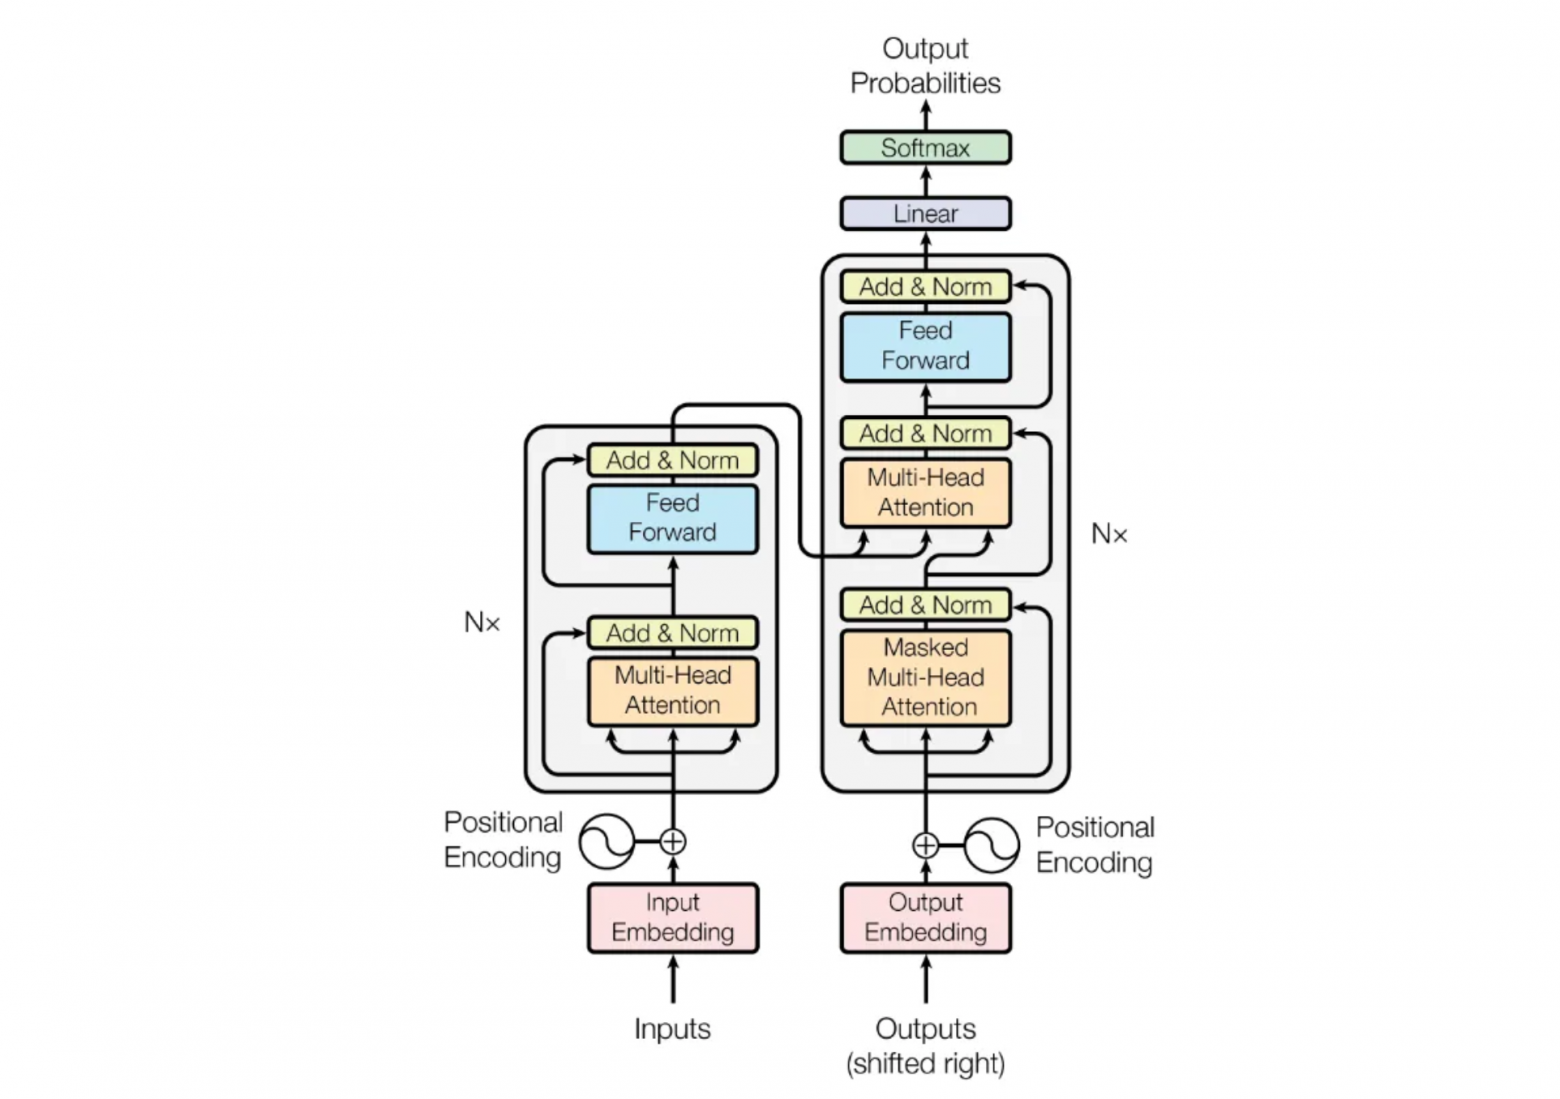

In [28]:
Image('1_3.png', width=600, height=600)

Рисунок 3, взят из оригинальной статьи.

Трансформер состоит из двух частей, называемых энкодер (слева внутри серого блока) и декодер (справа внутри серого блока). Для лучшей обработки информации каждый изображенный блок повторяется $N = 6$ раз, получая на вход результат работы предыдущего блока.
В энкодере символьное представление входной последовательности x переводится в z той же длины. При заданном $z$, Декодер затем генерирует выходную последовательность символов $(y_1, ..., y_m)$, по одному элементу за один раз. 

Собственно, все блоки трансформера мы уже рассмотрели и пояснений требуют только

1) связь энкодера и декодера (в частности, стрелочки от энкодера к декодеру)

2) финальные 2 блока в декодере

3) Input Embedding и Positional Encoding, Входные данные 

4) Masked Multi-head Attention и как это связано с утечкой данных

### 1) связь энкодера и декодера

Начнем с того, что получает декодер из энкодера. Выход верхнего энкодера  преобразуется в набор векторов внимания K и V для второго Mkulti-Head Sublayer'а декодера, т.е. в этом блоке вместо одной матрицы X у нас есть матрицы $X_1$ из энкодера и $X_2$ из предыдущих блоков декодера. $X_1$ умножается на $W_Q, W_K$, а $X_2$ - на $W_V$. Теперь интерпретация в виде соответствия запроса из энкодера документам из декодера имеет более глубокий смысл.

Это происходит для каждого декодера  (см. рисунок 4).

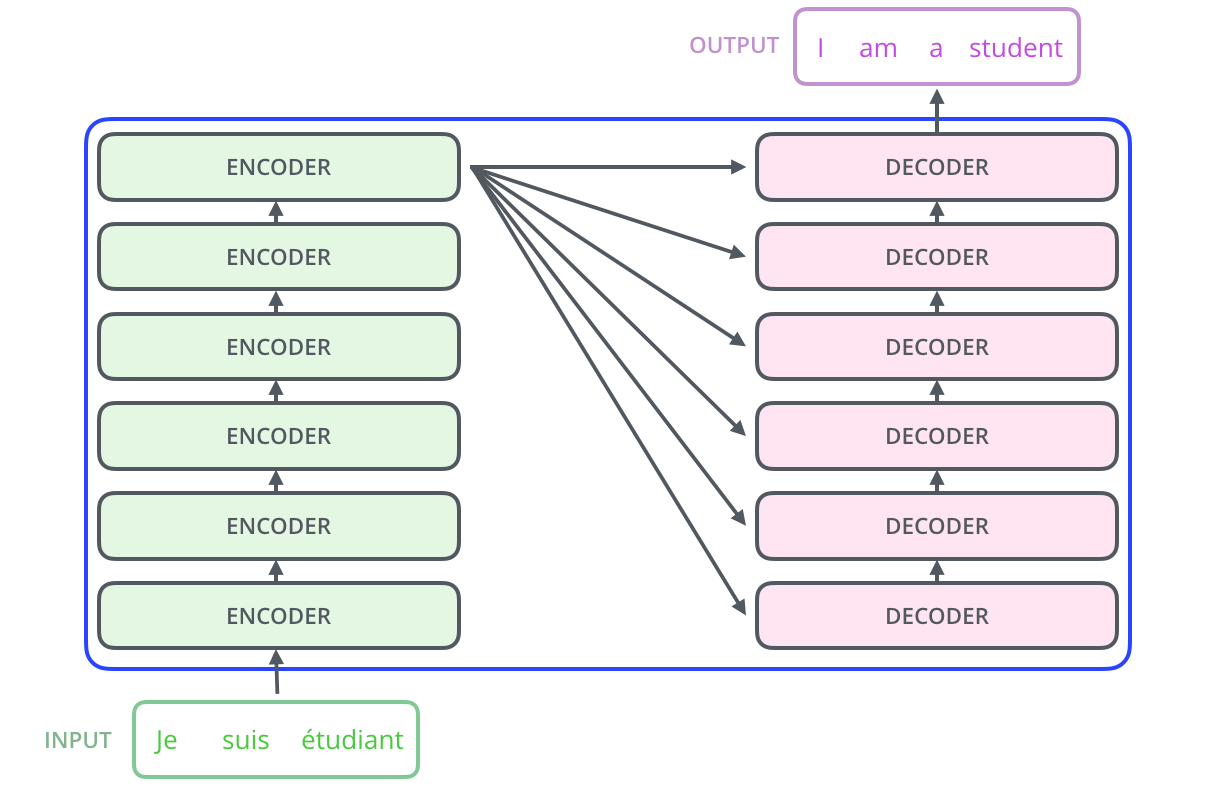

In [29]:
Image('1_4.png', width=600, height=600)

Рисунок 4.
https://habr.com/ru/articles/486358/

### 2) финальные 2 блока в декодере

Мы рассматриваем трансформер в контексте перевода, т.е. он получает предложение сразу и генерирует по одному слову на выходе. 

Сосредоточимся на последних двух слоях: Linear и Softmax.

Linear отображает выход предыдущей конструкции размера $d_{model}$ в пространство размерности $d_{dict}$ словаря, на основе которого модель формирует предложение.

Затем Softmax (формулу его мы видели когда разбирали Attention) приводит все координаты выхода Linear к масштабу [0, 1]. Это не что иное как вероятности каждого слова, и мы выбираем слово с наибольшей вероятностью, либо так, чтобы случайным образом выбиралось одно из слов с топовой вероятностью.

Полученное слово прибавляется к входному вектору декодера и процесс начинается заново, пока декодер не выдаст спецсимвол конца текста, либо пока не будет достигнут лимит длины текста.

### 3) Входные данные

Что приходит на вход энкодеру:

Input Embedding - превращает входящие текстовые токены в числовые эмбеддинги. В оригинале реализован следующим образом: берутся индексы токенов, над ними строится слой nn.Embedding, который обучается вместе с остальной моделью. Таким образом, модель получает на вход вектор слов размера B, на выходе - матрица размера $(B, d_{model})$. При этом если какие-то слова получили код длины меньше $d_{model}$, применяются паддинги - спецсимволы (обычно нули), вписываемые в конец или начало эмбеддингов так, чтобы все они имели одинаковую (максимальную) длину   

Positional Encoding - чтобы запомнить изначальные позиции слов, к матрице эмбеддингов прибавляются числа, заданные формулами
$$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}} ),$$
$$PE_{(pos,2i+1)} = cos(pos/10000^{2i/{d_model}} ),$$
где $i=0,..,d_{model}-1; pos=0,...,B-1$.

Что приходит на вход декодеру:

На этапе применения готового трансформера работа декодера начинается со спец. токена, обозначающего начало предложения, и первое слово декодера диктуется информацией, поступившей из энкодера, как мы рассмотрели выше. Затем получившаяся пара слов кодируется эмбеддером и позиционным энкодером (такими же, а в некоторых реализациях и теми же, что у энкодера) и поступает в нашу композицию шести декодер-блоков. 

В процессе обучения все выглядит несколько иначе: на вход подается все переводимое предложение, сдвинутое вправо символом начала текста (последнее слово, соответственно, уходит). Модель предсказывает все слова сразу, и обновляет веса. 

### 4) Masked Multi-Head Attention

Вспомним, что Attention устанавливает связи всех входящих эмбеддингов. Но на нижнем входе декодера у нас аккумулирующееся предложение, пока мы его составляли, мы не знали какое слово окажется следующим. Если ничего не делать, мы получаем информацию из будущего, что может испортить качество модели. Решение - занулить все элементы матрицы, стоящие выше диагонали, которые и имеют смысл "взгляда в будущее" (Например, первая строка - схожесть первого эмбеддинга с остальными, неизвестными на момент первого шага, поэтому в первой строке остается только первый элемент). Каким образом эти элементы зануляются - мы уже рассмотрели, когда изучали Attention.

### И вот, мы собрали наш трансформер! 

### И получили инсайты о его свойствах!

## 3. Заключение

Статья "Attention is All You Need" по праву считается одной из тех работ, которые переворачивают представление о предмете исследования. И ее гениальность не в сложности, а в правильной комбинации простых элементов (то за что лично я и полюбил математику по сравнению с остальными науками). Давайте выделим гениальные идеи, которые мы теперь видим.

### 1) Радикальное упрощение

До 2017: state-of-the-art модели для перевода (и других задач NLP) были невероятно сложными гибридами различных сложных слоев. Каждый такой слой в свою очередь держал в себе кучу математических выражений. Энкодер и декодер были многослойными рекуррентными сетями, а Attention был "костылём", который помогал тащить информацию через длинные последовательности.

Стало:
Полное удаление рекуррентности. Это был смелейший шаг.
Вся архитектура строится только на Attention и Feed-Forward слоях.
Модель стала концептуально проще и элегантнее.

### 2) Self-Attention: Мгновенный "глобальный обзор"

До 2017: Чтобы связать первое и последнее слово в тексте, информация должна "пройти" через все промежуточные состояния, постоянно "забываясь" и "искажаясь" (проблема исчезающих градиентов и другие неприятности).

Стало: Любые два слова в предложении "связываются" напрямую за один шаг. Расстояние между ними не имеет значения для механизма вычисления внимания. Модель с самого начала видит всю структуру целиком и гораздо лучше улавливает сложные, дальние зависимости в тексте.

### 3) Параллелизм и масштабируемость как следствие упрощения

Подача всей последовательности сразу — это не самоцель, а прямое следствие концептуальной замены RNN на скалярное произведение.

RNN: Последовательная обработка -> Нет параллелизма -> Медленное обучение.
Transformer: Матричные умножения над всей последовательностью -> Максимальный параллелизм -> Невероятно быстрые вычисления.

Это позволило тренировать модели на объемах данных, которые были немыслимы для RNN. Трансформер не просто лучше — он еще и лучше масштабируется. Да, вычислительная сложность растет с размером последовательности и модели, но вся архитектура идеально ложится на матричные операции, которые десятилетиями оптимизировались для GPU/TPU.

Это открыло дорогу к гигантским моделям (BERT, GPT, T5 и т.д.). С увеличением размера модели (размеров блоков, количество слоев) и объема данных, качество моделей стабильно росло. 

### 4) Универсальность

Гениальность также в том, что архитектура оказалась невероятно универсальной. Нам просто нужен некоторый набор эмбеддингов на вход, что нашло применение (пусть не в таком радикальном виде как для NLP) в Computer Vision, музыке, речи, биоинформатике и других областях. Архитектура стала универсальным инструментом для работы с любыми последовательными данными.

Помимо революционной архитектуры, оригинальная статья также отлично написана и структурирована. В заключении статьи авторы достаточно хорошо наметили тренды дальнейшего развития.

**В дальнейшем, исследователи также додумались использовать энкодер и декодер по отдельности, а к чему это все привело, мы посмотрим завтра.**
А почти все авторы оригинальной статьи после успеха трансформеров организовали свои стартапы. 

# Дополнительные материалы

Визуализация архитектуры трансформеров
https://bbycroft.net/llm

Хендбук по ML (основы)
https://education.yandex.ru/handbook/ml

Тут можно почитать про LayerNorm и Encoder https://docs.pytorch.org/docs/stable/index.html

(*) Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David Duvenaud (University of Toronto), Neural Ordinary Differential Equations https://arxiv.org/pdf/1806.07366, .

# Ссылки

0. Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin (Google), Attention Is All You Need, https://arxiv.org/abs/1706.03762

Код (обучающий материал) https://www.tensorflow.org/text/tutorials/transformer?hl=ru

1. Рисунки взяты из статей

Damien Benveniste, Understanding The Self-Attention Mechanism https://newsletter.theaiedge.io/p/understanding-the-self-attention

Просто файлообменник для картинок https://wishescards.ru/attention/layers/?utm_medium=organic&utm_source=yandexsmartcamera

Трансформер в картинках, Jay Alammar (перевод Kouki_RUS) https://habr.com/ru/articles/486358/

2. Как работают трансформеры: разбираем математику, PatientZero,
https://habr.com/ru/amp/publications/785474/

3. Пишем свой трансформер, anikengur,
https://habr.com/ru/articles/891972/
 